In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#pus = tf.config.experimental.list_physical_devices('GPU')
#f gpus:
#   try:
#       tf.config.experimental.set_virtual_device_configuration(
#           gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
#   except RuntimeError as e:
#       print(e)

### Define the network architecture
* `input_img` is our input image
* `encoded` is the encoded representation of the input
* `decoded` is the lossy reconstruction of the input
* The `autoencoder` model maps an input to its reconstruction

In [ ]:
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

input_img = keras.Input(shape=(784,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

Create separate `encoder` and `decoder` models for further use.

In [ ]:
encoder = keras.Model(input_img, encoded)

In [ ]:
encoded_input = keras.Input(shape=(encoding_dim,)) # encoded (32-dimensional) input
decoder_layer = autoencoder.layers[-1] # the last layer from our autoencoder
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse') # binary_crossentropy

Load and pre-process the data

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

Add the noise to the digits images

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Check what the first 10 images look like

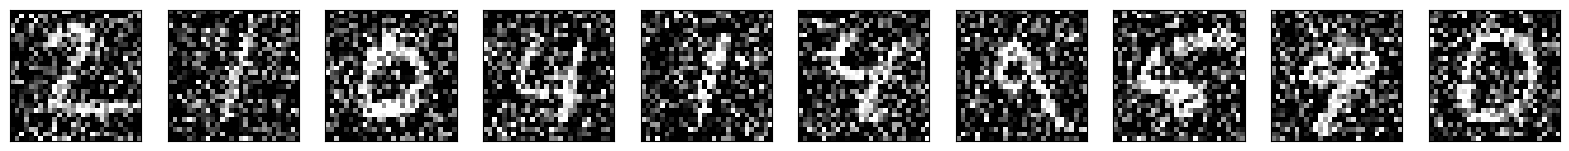

In [ ]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Train the model for 50 epochs

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=1)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1019 - val_loss: 0.0733
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0463 - val_loss: 0.0684
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0378 - val_loss: 0.0704
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0328 - val_loss: 0.0723
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0293 - val_loss: 0.0719
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0269 - val_loss: 0.0697
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0251 - val_loss: 0.0682
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0236 - val_loss: 0.0681
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0230 - val_loss: 0.0671
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0225 - val_loss: 0.0673
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0222 - val_loss: 0.0659
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

After training the model, encode and decode some digits.
Note that we take them from the *test* set

In [ ]:
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Now, visualize the result

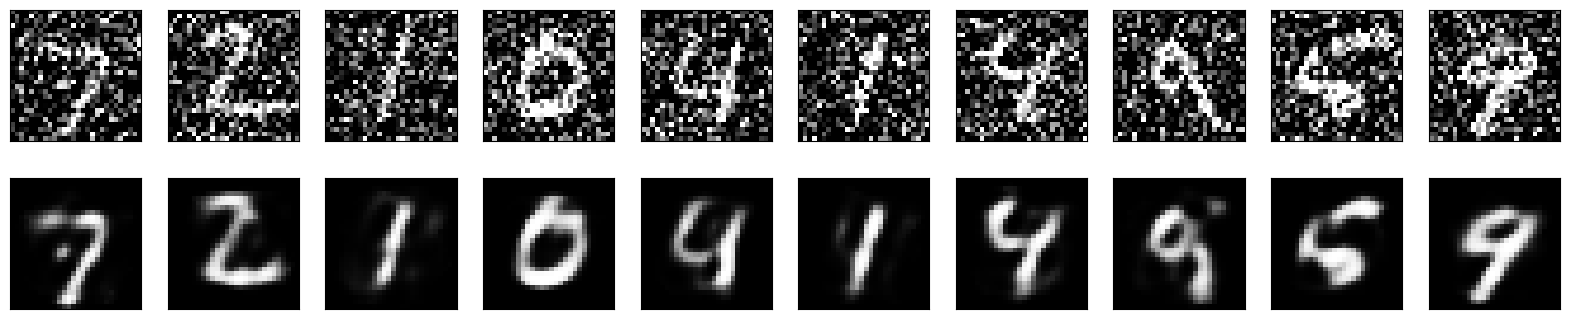

In [ ]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Exercise
1. The FVC 2002 has a [fingerprint dataset](http://bias.csr.unibo.it/fvc2002/databases.asp). Please, check if any of the Autoencoders architecture is good enough for recriating fingerprints. In case you need some inspiration, you can check [this](https://www.kdnuggets.com/2020/03/recreating-fingerprints-using-convolutional-autoencoders.html) kdnuggets post.
1. (Extra) Check [this](https://www.kaggle.com/c/denoising-dirty-documents/code) kaggle competition on how to get rid of noise in scanned documents.